In [2]:
import re
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 加载数据

In [3]:
train = json.load(open('data/round1_train_0907.json'))
test = json.load(open('data/round1_test_0907.json'))

In [4]:
def json2df(dic):
    D = {'passage': list(), 'question': list(), 'answer': list()}
    for d in dic:
        for qa in d['annotations']:
            D['passage'].append(d['text'])
            D['question'].append(qa['Q'])
            D['answer'].append(qa['A'])
            
    return pd.DataFrame(D)

In [5]:
df_train = json2df(train)
df_test = json2df(test)

# 简单查看数据

In [6]:
df_train.head()

,passage,question,answer
0,"""胆石症的治疗应区别不同情况分别处理，无症状胆囊结石可不作治疗，但应定期观察并注意良好的饮食...",什么类型的胆囊结石可不作治疗？,无症状胆囊结
1,"""胆石症的治疗应区别不同情况分别处理，无症状胆囊结石可不作治疗，但应定期观察并注意良好的饮食...",胆石症的治疗应注意什么？,应区别不同情况分别处理
2,"""胆石症的治疗应区别不同情况分别处理，无症状胆囊结石可不作治疗，但应定期观察并注意良好的饮食...",胆管结石宜采用什么样的治疗方式？,以手术为主的综合治疗
3,反佐配伍的典范，始见于张仲景《伤寒杂病论》，其中记载“干呕、吐涎沫、头痛者吴茱萸汤主之”。患...,“干呕、吐涎沫、头痛者吴茱萸汤主之”这句话曾出现在哪本医学巨著中？,《伤寒杂病论》
4,反佐配伍的典范，始见于张仲景《伤寒杂病论》，其中记载“干呕、吐涎沫、头痛者吴茱萸汤主之”。患...,《伤寒杂病论》的作者是谁？,张仲景


In [7]:
df_test.head()

,passage,question,answer
0,"""橄榄，又名青果、白榄，为橄榄科植物橄榄的果实，产广东、广西、福建等地。宋朝大文学家苏东坡称...",,橄榄的果实中含有蛋白质、脂肪、碳水化合物以及钙.磷、铁等。
1,"""橄榄，又名青果、白榄，为橄榄科植物橄榄的果实，产广东、广西、福建等地。宋朝大文学家苏东坡称...",,清肺，利咽，生津：解毒
2,"""橄榄，又名青果、白榄，为橄榄科植物橄榄的果实，产广东、广西、福建等地。宋朝大文学家苏东坡称...",,青子
3,"""橄榄，又名青果、白榄，为橄榄科植物橄榄的果实，产广东、广西、福建等地。宋朝大文学家苏东坡称...",,主治咽喉肿痛，烦渴，咳嗽咯血以及细菌性痢疾、癫痫等，还能解除河豚毒以及酒毒。
4,黄帝说：我想听听运气学说是怎样创始的。岐伯说：你提这个问题很高明的啊！我曾看到《太始天元册》...,,赤色的天气，经过牛、女二宿及西北方的戊分；黄色的天气，经过心、尾二宿及东南方的已分；青色的天...


In [8]:
len(df_train)

18478

In [9]:
len(df_test)

4373

# 数据预处理

In [10]:
# 剔除空白字符
df_train = df_train.applymap(lambda x: re.sub(r'\s', '', x))
df_train = df_train.applymap(lambda x: re.sub(r'\\n', '', x))
df_test = df_test.applymap(lambda x: re.sub(r'\s', '', x))
df_test = df_test.applymap(lambda x: re.sub(r'\\n', '', x))

In [11]:
# 剔除带括号的英文
func = lambda m: '' if len(m.group(0)) > 5 else m.group(0)
df_train = df_train.applymap(lambda x: re.sub(r'\([A-Za-z]+\)', func, x))
df_train = df_train.applymap(lambda x: re.sub(r'（[A-Za-z]+）', func, x))
df_test = df_test.applymap(lambda x: re.sub(r'\([A-Za-z]+\)', func, x))
df_test = df_test.applymap(lambda x: re.sub(r'（[A-Za-z]+）', func, x))

# 文本长度分布

## describe
通过数据描述可以看到：
* 训练集共18478条文本数据；
    * 篇章文本平均358个字符，最短的句子长度为40，最长的句子长度为511，其中75%以下的数据长度在453以下；
    * 问题文本平均14个字符，最短的句子长度为5，最长的句子长度为130，其中75%以下的数据长度在17以下；
    * 答案文本平均47个字符，最短的句子长度为1，最长的句子长度为508，其中75%以下的数据长度在58以下。
* 测试集共4373条文本数据；
    * 篇章文本平均353个字符，最短的句子长度为46，最长的句子长度为511，其中75%以下的数据长度在449以下；
    * 答案文本平均48个字符，最短的句子长度为1，最长的句子长度为508，其中75%以下的数据长度在59以下。

In [12]:
df_train.passage.map(lambda x: len(x.strip())).describe()

count    18478.000000
mean       358.024678
std        108.896379
min         40.000000
25%        283.000000
50%        376.000000
75%        453.000000
max        511.000000
Name: passage, dtype: float64

In [13]:
df_train.question.map(lambda x: len(x.strip())).describe()

count    18478.000000
mean        14.386947
std          6.500708
min          5.000000
25%         10.000000
50%         13.000000
75%         17.000000
max        130.000000
Name: question, dtype: float64

In [14]:
df_train.answer.map(lambda x: len(x.strip())).describe()

count    18478.000000
mean        47.635675
std         50.482854
min          1.000000
25%         19.000000
50%         34.000000
75%         58.000000
max        508.000000
Name: answer, dtype: float64

In [15]:
df_test.passage.map(lambda x: len(x.strip())).describe()

count    4373.000000
mean      353.149325
std       111.697666
min        46.000000
25%       273.000000
50%       374.000000
75%       449.000000
max       511.000000
Name: passage, dtype: float64

In [16]:
df_test.answer.map(lambda x: len(x.strip())).describe()

count    4373.000000
mean       48.533501
std        53.045020
min         1.000000
25%        19.000000
50%        34.000000
75%        59.000000
max       508.000000
Name: answer, dtype: float64

## 直方图
通过直方图可以看到：
* 篇章文本长度在100以下的数据较少，长度区间400-500的数据占比较大。
* 问题文本长度主要集中在5-20这个区间，长度40以上的数据较少。
* 答案文本长度主要集中在1-100区间，长度200以上的数据较少。

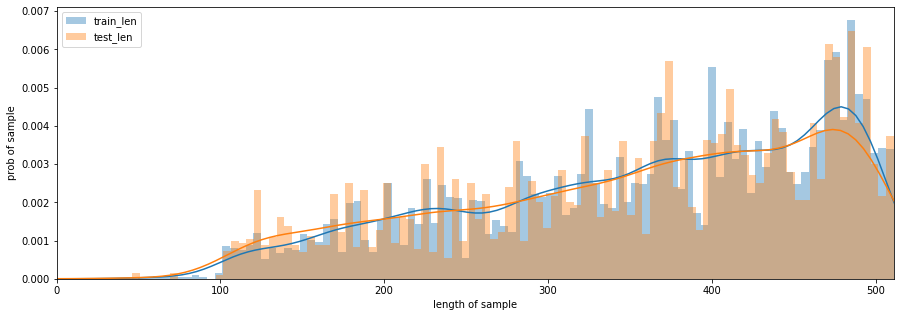

In [19]:
plt.figure(figsize=(15,5))
ax = sns.distplot(df_train.passage.map(lambda x: len(x.strip())).values, bins=100)
ax = sns.distplot(df_test.passage.map(lambda x: len(x.strip())).values, bins=100)
plt.xlim([0, max(max(df_train.passage.map(lambda x: len(x.strip())).values), max(df_test.passage.map(lambda x: len(x.strip())).values))])
plt.xlabel("length of sample")
plt.ylabel("prob of sample")
plt.legend(['train_len','test_len'])

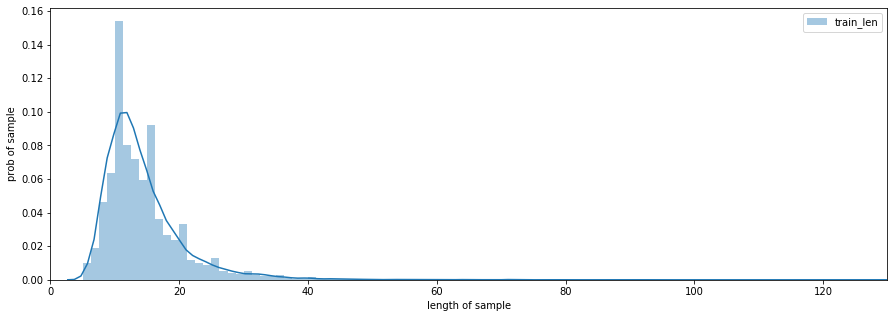

In [22]:
plt.figure(figsize=(15,5))
ax = sns.distplot(df_train.question.map(lambda x: len(x.strip())).values, bins=100)
plt.xlim([0, max(df_train.question.map(lambda x: len(x.strip())).values)])
plt.xlabel("length of sample")
plt.ylabel("prob of sample")
plt.legend(['train_len'])

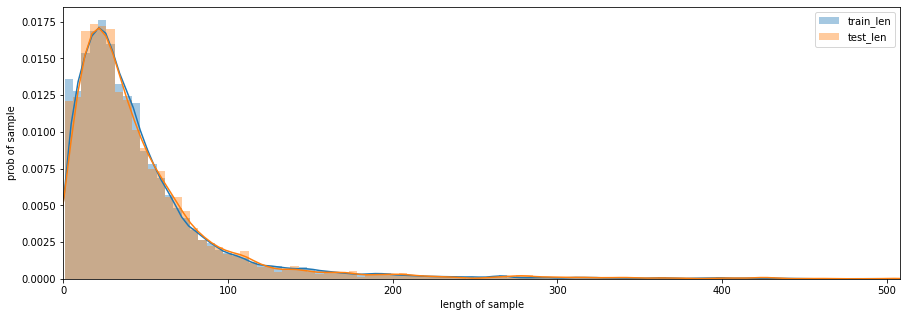

In [23]:
plt.figure(figsize=(15,5))
ax = sns.distplot(df_train.answer.map(lambda x: len(x.strip())).values, bins=100)
ax = sns.distplot(df_test.answer.map(lambda x: len(x.strip())).values, bins=100)
plt.xlim([0, max(max(df_train.answer.map(lambda x: len(x.strip())).values), max(df_test.answer.map(lambda x: len(x.strip())).values))])
plt.xlabel("length of sample")
plt.ylabel("prob of sample")
plt.legend(['train_len','test_len'])

## 同分布验证
* 篇章的P值为0.03，比指定的显著水平（假设为5%）小，我们认为二者不是同分布。
* 答案的P值为0.84，比指定的显著水平（假设为5%）小，我们认为二者同分布。

In [24]:
import scipy
scipy.stats.ks_2samp(df_train.passage.map(lambda x: len(x.strip())).values, df_test.passage.map(lambda x: len(x.strip())).values)

Ks_2sampResult(statistic=0.023524541901201457, pvalue=0.039927605323010484)

In [25]:
scipy.stats.ks_2samp(df_train.answer.map(lambda x: len(x.strip())).values, df_test.answer.map(lambda x: len(x.strip())).values)

Ks_2sampResult(statistic=0.01037905238055789, pvalue=0.8407291806931478)

# 分析总结
* 训练数据量适中，不是很大数据量，但是也不算少。
* 文本长度：篇章文本最大，其次是答案文本，最后是问题文本。
* 如果只看答案文本，那它的长度分布应该是同分布。
* 若要将篇章、问题和答案拼接进行训练，则需要对其进行文本截断；
    * 问题是要预测的部分，并且长度不是太长，所以可以不进行截断；
    * 答案是从篇章中截取的，可以适当截取短一点；
    * 篇章在硬件资源允许的范围内，可以尽量截取长一点。